# Importing the Libraries

In [304]:
# !pip install osmnx
# !pip install geopandas
# !pip install numpy==1.21.*
# !pip install pandas==1.3.*
# !pip install --upgrade numba
# !pip install spaghetti==1.6.5
import networkx as nx
import osmnx as ox
import random
import pandas as pd
import pyproj # to convert the coordinates
from geopandas import GeoDataFrame
from shapely.geometry import Point, LineString
import spaghetti
import matplotlib.pyplot as plt
import numpy as np
import esda

# Task A - Spatial Networks and Planarity

## Creating the Dataframe of the accidents

In [305]:
accidents_2019 = pd.read_csv("Traffic accidents_2019_Leeds.csv")
accidents_2018 = pd.read_csv("RTC 2018_Leeds.csv")

print("Total accidents of Leeds in 2019:", accidents_2019.shape[0])
print("Total accidents of Leeds in 2018:", accidents_2018.shape[0])

print("----Null Values 2019----")
print(accidents_2019.isnull().sum())
print("----Null Values 2018----")
print(accidents_2018.isnull().sum())

# leavimg only the columns with the coordinates
accidents_2019 = accidents_2019[['Grid Ref: Easting', 'Grid Ref: Northing']]
accidents_2018 = accidents_2018[['Grid Ref: Easting', 'Grid Ref: Northing']]

accidents = pd.concat([accidents_2019, accidents_2018], ignore_index=True)
print("Total no. of accidents loaded: {}".format(len(accidents)))

Total accidents of Leeds in 2019: 1907
Total accidents of Leeds in 2018: 1995
----Null Values 2019----
Reference Number       0
Grid Ref: Easting      0
Grid Ref: Northing     0
Number of Vehicles     0
Accident Date          0
Time (24hr)            0
1st Road Class         0
1st Road Class & No    0
Road Surface           0
Lighting Conditions    0
Weather Conditions     0
Local Authority        0
Vehicle Number         0
Type of Vehicle        0
Casualty Class         0
Casualty Severity      0
Sex of Casualty        0
Age of Casualty        0
dtype: int64
----Null Values 2018----
Accident Fields_Reference Number    0
Grid Ref: Easting                   0
Grid Ref: Northing                  0
Number of Vehicles                  0
Accident Date                       0
Time (24hr)                         0
1st Road Class                      0
1st Road Class & No                 0
Road Surface                        0
Lighting Conditions                 0
Weather Conditions           

## Convering the coordinates of the accidents from BNG (British National Grid) to WSG85 (Latitude, Longitude)

In [306]:
from pyproj import Proj, transform

def convert_bng_to_wgs84(df):
    # Defining the BNG and WGS84 coordinate systems
    inProj = Proj(init='epsg:27700') # BNG
    outProj = Proj(init='epsg:4326')# WGS84
    
    # Converting the BNG coordinates to WGS84 for each row
    longitude_list = []
    latitude_list = []
    for index, row in df.iterrows():
        bng_easting = row["Grid Ref: Easting"]
        bng_northing = row["Grid Ref: Northing"]
        longitude, latitude = transform(inProj, outProj, bng_easting, bng_northing)
        longitude_list.append(longitude)
        latitude_list.append(latitude)
        
    # Adding the WGS84 coordinates as new columns to the dataframe
    df["Longitude"] = longitude_list
    df["Latitude"] = latitude_list
    
    # Dropping the original BNG columns from the dataframe
    df = df.drop(columns=["Grid Ref: Easting", "Grid Ref: Northing"])
    
    return df
   
final_accidents = convert_bng_to_wgs84(accidents)
final_accidents

/Users/anthoskountouris/miniconda3/envs/nda/lib/python3.9/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/anthoskountouris/miniconda3/envs/nda/lib/python3.9/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/f7/5b6xj7tx2j980czxfkmrn8y00000gn/T/ipykernel_92657/3235624286.py:14: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io

Longitude   Latitude
0     -1.452556  53.809670
1     -1.452556  53.809670
2     -1.452556  53.809670
3     -1.452556  53.809670
4     -1.452556  53.809670
...         ...        ...
3897  -1.514842  53.743084
3898  -1.514842  53.743084
3899  -1.514842  53.743084
3900  -1.514842  53.743084
3901  -1.547648  53.795846

[3902 rows x 2 columns]

## Using the point of interest to create the graph

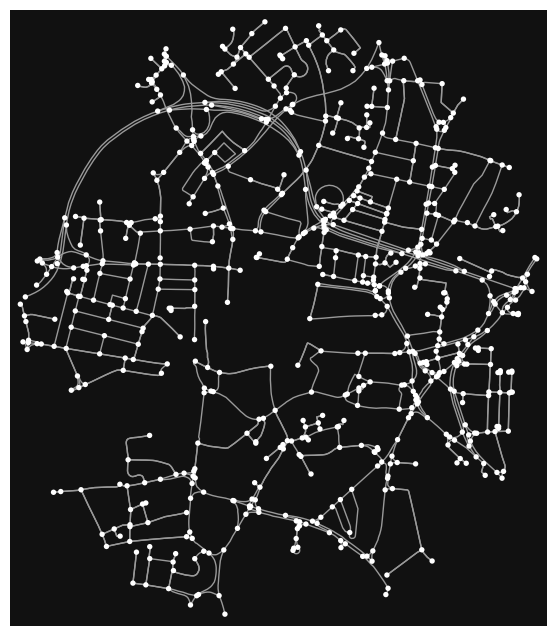

(<Figure size 800x800 with 1 Axes>, <AxesSubplot:>)

In [307]:
# Choose a place whose accidents we will analyse with respect to its street network
PLACE_OF_INTEREST = "Briggate, Leeds, United Kingdom"
# PLACE_OF_INTEREST = "Leeds City Centre, Leeds, United Kingdom"
leeds_city_center_area = ox.geocode_to_gdf(PLACE_OF_INTEREST, buffer_dist=1000)

# From this take the polygon that defines selected area'sboundary
leeds_city_center_polygon = leeds_city_center_area['geometry'][0]
# Creating the graph
leeds_city_center_network = ox.graph_from_polygon(leeds_city_center_polygon, network_type='drive')
ox.plot_graph(leeds_city_center_network)

In [308]:
ox.plot_graph_folium(leeds_city_center_network)

## Filtering the accidents to only include those within the chosen area

In [309]:
# Translating to a GeoDatFrame where the geometry is given by a Point constructed from the longitude and latitude
accident_points = GeoDataFrame(geometry=[Point(xy) for xy in zip(
    final_accidents.Longitude, final_accidents.Latitude)])
print("Total no. of located accidents filtered: {}".format(len(accident_points)))
# Filtering the accident points to just those within the selected Leeds area, as defined by the polygon found earlier
leeds_accidents = accident_points[accident_points.geometry.within(leeds_city_center_polygon)]
print("There are {} accidents in the selected area.".format(leeds_accidents.shape[0]))

Total no. of located accidents filtered: 3902
There are 344 accidents in the selected area.


# Statistics of the road network (Task A.1, A.2 , A.3)|

## Computing the basic statistics of the road network based on the graph and the area (Task A.1-2)

### Diameter (Task A.1)

In [310]:
ox.extended_stats(leeds_city_center_network, ecc=True)['diameter']

/Users/anthoskountouris/miniconda3/envs/nda/lib/python3.9/site-packages/osmnx/stats.py:458: UserWarning: The extended_stats function has been deprecated and will be removed in a future release. Use NetworkX directly for extended topological measures.
  warnings.warn(msg)


5847.585999999999

In [311]:
# source code
# https://github.com/gboeing/osmnx/blob/54ee4be1e65c33a41c5751a3ea80a195987a6582/osmnx/stats.py

# getting the largest strongly connected component of the network
lg_str_con_comp = ox.utils_graph.get_largest_component(leeds_city_center_network, strongly=True)
# computing the shortest path distances from every node to every other node in the lg_str_con_comp
shortest_path_distances = {source:dict(nx.single_source_dijkstra_path_length(lg_str_con_comp, source, weight='length')) for source in lg_str_con_comp.nodes()}
# computing the eccentricity of each node in the largest strongly connected component using the shortest_path_distances
eccentricity = nx.eccentricity(lg_str_con_comp, sp=shortest_path_distances)
# computing the diameter of the largest strongly connected component
diameter = nx.diameter(lg_str_con_comp, e = eccentricity)
diameter


5847.585999999999

### Basic Stats (Task A.2)

In [312]:
leeds_city_centre_area = ox.project_gdf(leeds_city_center_area).unary_union.area
stats = ox.basic_stats(leeds_city_center_network, area=leeds_city_centre_area)
stats

{'n': 706,
 'm': 1293,
 'k_avg': 3.6628895184135977,
 'edge_length_total': 86303.11899999995,
 'edge_length_avg': 66.74641840680584,
 'streets_per_node_avg': 2.831444759206799,
 'streets_per_node_counts': {0: 0, 1: 104, 2: 26, 3: 470, 4: 97, 5: 9},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.14730878186968838,
  2: 0.036827195467422094,
  3: 0.6657223796033994,
  4: 0.13739376770538245,
  5: 0.012747875354107648},
 'intersection_count': 602,
 'street_length_total': 65183.280999999806,
 'street_segment_count': 963,
 'street_length_avg': 67.68772689511921,
 'circuity_avg': 1.0403168081086958,
 'self_loop_proportion': 0.0010384215991692627,
 'node_density_km': 182.08941267832364,
 'intersection_density_km': 155.2660431053128,
 'edge_density_km': 22259.042848466663,
 'street_density_km': 16811.877271580874}

## Checking for planarity of the road network (Task A.3)

In [313]:
'''
The graph is not planar, which means that it is not possible to draw the graph in 2D without
any edges crossing.
'''
is_planar, kuratowski_subgraphs = nx.check_planarity(leeds_city_center_network,counterexample=True)
is_planar

False

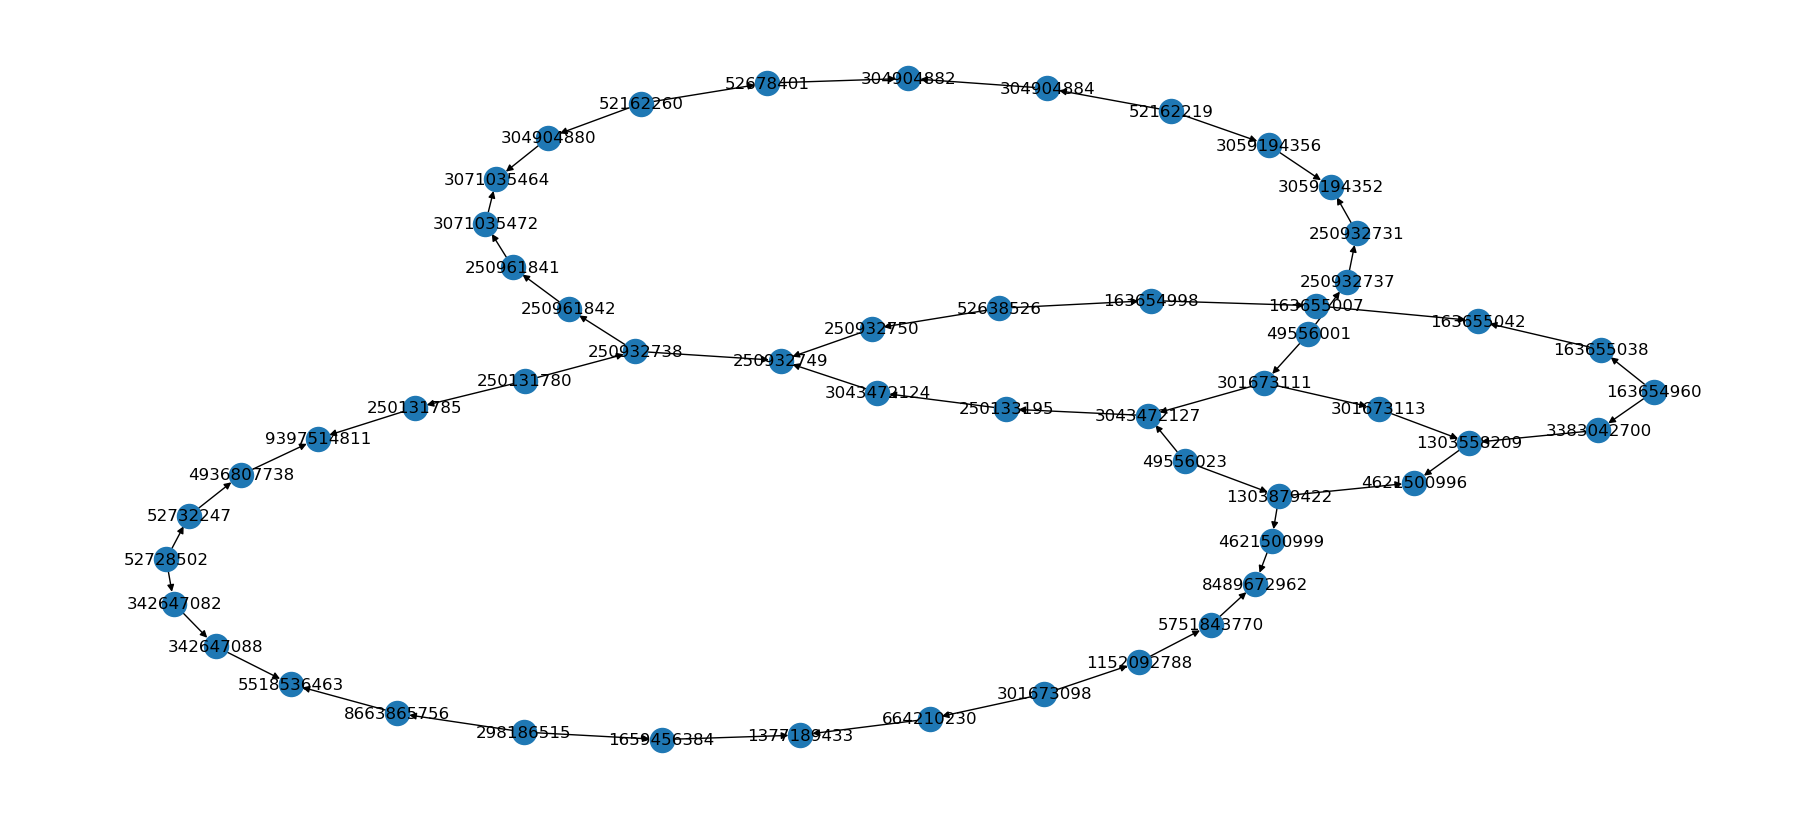

In [314]:
plt.figure(figsize=(18, 8))
nx.draw(kuratowski_subgraphs, pos=nx.kamada_kawai_layout(kuratowski_subgraphs), arrows=True, arrowstyle='-|>', with_labels=True)
# save this figure
plt.savefig('kuratowski_subgraphs.png', dpi=300, bbox_inches='tight')
plt.show()

# Task B - Road Accidents

## Adding geometry to the edges which so do not have. (Task B.1)

In [315]:
# nodes are specified by x, y, coordinat
list(leeds_city_center_network.nodes(data=True))[0:10]

[(611055, {'y': 53.7934435, 'x': -1.5350094, 'street_count': 3}),
 (611057, {'y': 53.7950006, 'x': -1.533947, 'street_count': 3}),
 (643844, {'y': 53.7901803, 'x': -1.5390609, 'street_count': 3}),
 (643851, {'y': 53.7956485, 'x': -1.5326979, 'street_count': 4}),
 (643907, {'y': 53.7983902, 'x': -1.5360412, 'street_count': 3}),
 (643911, {'y': 53.7964981, 'x': -1.5348803, 'street_count': 3}),
 (643914, {'y': 53.7965251, 'x': -1.5343196, 'street_count': 4}),
 (643929, {'y': 53.7950089, 'x': -1.5381171, 'street_count': 3}),
 (643930, {'y': 53.7951126, 'x': -1.540124, 'street_count': 3}),
 (643933, {'y': 53.7944708, 'x': -1.5422822, 'street_count': 4})]

In [316]:
# the edges are tuples of start node, end node and a dictionary with attributes including geometry
'''
Some edges have a geometry attribute, which is a LineString object, and some others may not. The geometry
isimportant because it's allowing us to plot the edge on the map on a 2 dimensional space. The shape of the
edge is not just a straight line between two points. The shape of the edge is approximating the actual shape
of the street in the real world. One possible way to address this would be include extra nodes in some spatial
positions to approximate the shape of the actual road.

'''
list(leeds_city_center_network.edges(data=True))[0:3]

[(611055,
  342626322,
  {'osmid': [4372315, 4326732],
   'bridge': 'yes',
   'lanes': '3',
   'ref': 'A653',
   'name': ['Crown Point Bridge', 'Crown Point Road'],
   'highway': 'secondary',
   'maxspeed': '30 mph',
   'oneway': False,
   'length': 95.57900000000001,
   'geometry': <shapely.geometry.linestring.LineString at 0x7fc0f5f0c160>}),
 (611055,
  317020454,
  {'osmid': 4326736,
   'oneway': True,
   'lanes': '2',
   'ref': 'A653',
   'name': 'Black Bull Street',
   'highway': 'secondary',
   'maxspeed': '30 mph',
   'length': 67.908,
   'geometry': <shapely.geometry.linestring.LineString at 0x7fc0f5f0c580>}),
 (611057,
  6047609602,
  {'osmid': 229127796,
   'oneway': True,
   'lanes': '4',
   'ref': 'A61',
   'name': 'East Street',
   'highway': 'trunk',
   'maxspeed': '30 mph',
   'length': 17.615})]

In [317]:
# It is possible that certain edges in the dataset do not have a specified geometry. 
# To address this, we will generate a new geometry by assuming that the road is a 
# straight line between its start and end points. In order to do this, we must first 
# obtain the locations of these points.

# Getting the x and y coordinates of the nodes
x_values = nx.get_node_attributes(leeds_city_center_network, 'x')
y_values = nx.get_node_attributes(leeds_city_center_network, 'y')

# Our task involves processing the edges in the dataset and filling in any missing geometries.
# These geometries represent the lines that indicate the roads between two points.

# Creating a list of edges with attributes
graph_with_geometries = list(leeds_city_center_network.edges(data=True))

# Iterating through the edges and, where missing, add a geometry attribute with the line between start and end nodes
for e in graph_with_geometries:
    if not 'geometry' in e[2]:
        e[2]['geometry'] = LineString([
            Point(x_values[e[0]], y_values[e[0]]),
            Point(x_values[e[1]], y_values[e[1]])])

graph_with_geometries[0:4]

graph_with_geometries_c = graph_with_geometries

In [318]:
graph_with_geometries

[(611055,
  342626322,
  {'osmid': [4372315, 4326732],
   'bridge': 'yes',
   'lanes': '3',
   'ref': 'A653',
   'name': ['Crown Point Bridge', 'Crown Point Road'],
   'highway': 'secondary',
   'maxspeed': '30 mph',
   'oneway': False,
   'length': 95.57900000000001,
   'geometry': <shapely.geometry.linestring.LineString at 0x7fc0f5f0c160>}),
 (611055,
  317020454,
  {'osmid': 4326736,
   'oneway': True,
   'lanes': '2',
   'ref': 'A653',
   'name': 'Black Bull Street',
   'highway': 'secondary',
   'maxspeed': '30 mph',
   'length': 67.908,
   'geometry': <shapely.geometry.linestring.LineString at 0x7fc0f5f0c580>}),
 (611057,
  6047609602,
  {'osmid': 229127796,
   'oneway': True,
   'lanes': '4',
   'ref': 'A61',
   'name': 'East Street',
   'highway': 'trunk',
   'maxspeed': '30 mph',
   'length': 17.615,
   'geometry': <shapely.geometry.linestring.LineString at 0x7fc0a0abda30>}),
 (643844,
  9025277255,
  {'osmid': 4326735,
   'oneway': True,
   'lanes': '1',
   'ref': 'A653',
   

## Dropping the start and end nodes. (Task B.1)

In [319]:
# We will now drop the start and end nodes, as we will construct a new Spaghetti network
# based on the geometries of the roads
road_lines = [x[2] for x in graph_with_geometries]
# From this, we can construct a GeoDataFrame
roads_geodataframe = GeoDataFrame(pd.DataFrame(road_lines))
roads_geodataframe

osmid bridge lanes   ref  \
0                 [4372315, 4326732]    yes     3  A653   
1                            4326736    NaN     2  A653   
2                          229127796    NaN     4   A61   
3                            4326735    NaN     1  A653   
4               [5944514, 648548326]    NaN     3  A653   
...                              ...    ...   ...   ...   
1288                      1140577792    NaN     2   NaN   
1289                       315813917    NaN   NaN   NaN   
1290                       315813916    NaN   NaN   NaN   
1291                       315813917    NaN   NaN   NaN   
1292  [8094914, 315813917, 39428286]    NaN     1   NaN   

                                        name         highway maxspeed  oneway  \
0     [Crown Point Bridge, Crown Point Road]       secondary   30 mph   False   
1                          Black Bull Street       secondary   30 mph    True   
2                                East Street           trunk   30 mph    True   
3                           Crown Point Road  secondary_link   30 mph    True   
4        [Great Wilson Street, Hunslet Lane]         primary   30 mph    True   
...                                      ...             ...      ...     ...   
1288                            North Street       secondary   30 mph    True   
1289                               Mark Lane    unclassified   20 mph   False   
1290                               Mark Lane    unclassified   20 mph   False   
1291                               Mark Lane    unclassified   20 mph   False   
1292               [Mark Lane, New Briggate]    unclassified   20 mph   False   

       length                                           geometry junction  \
0      95.579  LINESTRING (-1.53501 53.79344, -1.53483 53.793...      NaN   
1      67.908  LINESTRING (-1.53501 53.79344, -1.53516 53.793...      NaN   
2      17.615  LINESTRING (-1.53395 53.79500, -1.53408 53.79514)      NaN   
3      62.680  LINESTRING (-1.53906 53.79018, -1.53922 53.790...      NaN   
4      97.438  LINESTRING (-1.53906 53.79018, -1.53990 53.790...      NaN   
...       ...                                                ...      ...   
1288    8.397  LINESTRING (-1.53936 53.80111, -1.53934 53.801...      NaN   
1289    2.161  LINESTRING (-1.54340 53.79984, -1.54337 53.79984)      NaN   
1290   17.183  LINESTRING (-1.54337 53.79984, -1.54321 53.79996)      NaN   
1291    2.161  LINESTRING (-1.54337 53.79984, -1.54340 53.79984)      NaN   
1292  126.223  LINESTRING (-1.54337 53.79984, -1.54254 53.799...      NaN   

     access tunnel  
0       NaN    NaN  
1       NaN    NaN  
2       NaN    NaN  
3       NaN    NaN  
4       NaN    NaN  
...     ...    ...  
1288    yes    NaN  
1289    yes    NaN  
1290    NaN    NaN  
1291    yes    NaN  
1292    yes    NaN  

[1293 rows x 13 columns]

## Constructing the Spaghetti network based on the geometries of the network (Task B.1)

In [320]:
# From the GeoDataFrame, we can construct a network in Spaghetti from which to do point analysis
leeds_accident_area_graph = spaghetti.Network(in_data=roads_geodataframe)

In [321]:
# components of the network
leeds_accident_area_graph.network_n_components

1

In [322]:
# is the component of the network an isolated ring (or not)?
leeds_accident_area_graph.network_component_is_ring

{0: False}

In [323]:
# number of network arcs are associated with the component.
arcs = len(leeds_accident_area_graph.network_component2arc[leeds_accident_area_graph.network_component_labels[0]])
arcs

4184

## Visualising the network (Task B.1)

<AxesSubplot:>

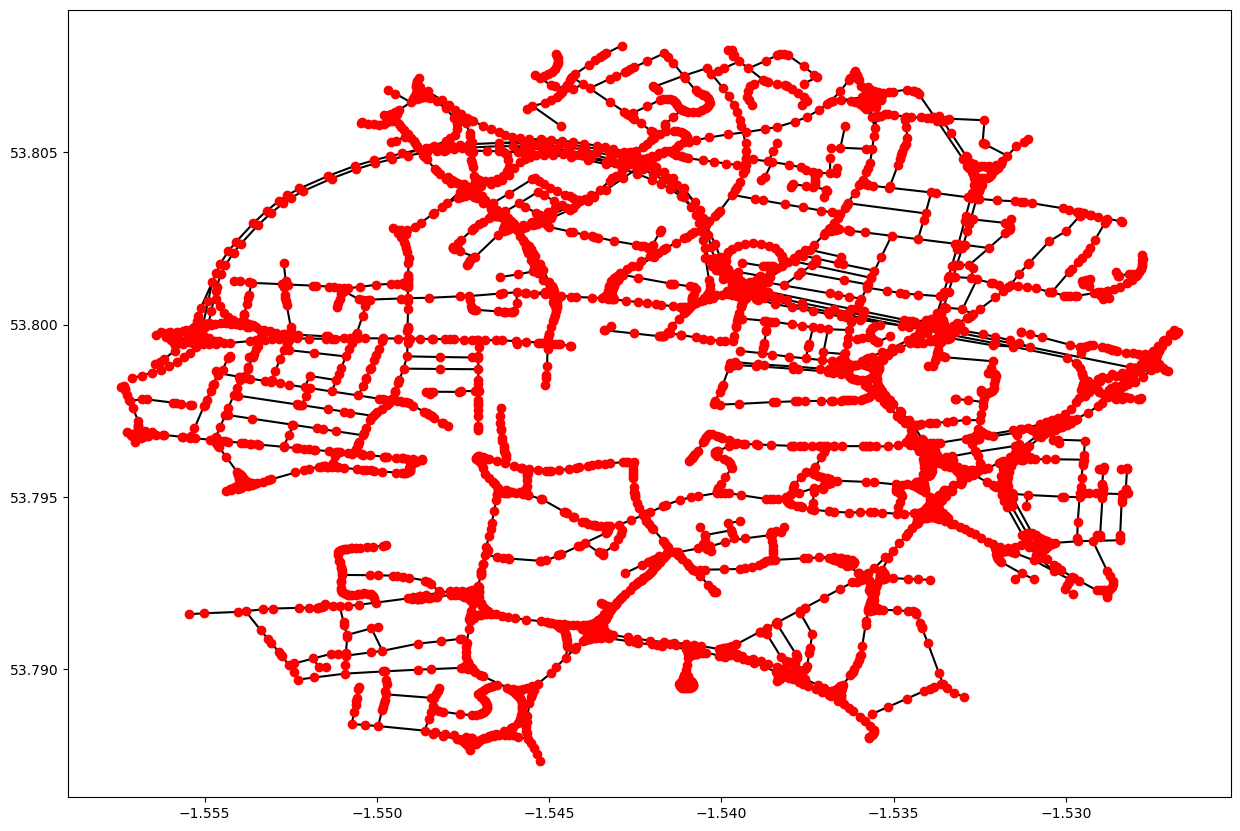

In [324]:
# To visualize the newly created network, we can generate DataFrames for the edges 
# and plot them. This will allow us to examine the structure and characteristics of the network.

nodes_df, edges_df = spaghetti.element_as_gdf(
    leeds_accident_area_graph, vertices=True, arcs=True)

base_network = edges_df.plot(color = "k", zorder=0, figsize=(15, 15))
nodes_df.plot(ax=base_network, color="r", zorder=2)

## Translating latitude and longitude of the accidents to Point objects (Task B.1)

### Snapping the accidents

In [325]:
# We will now snap the accidents, position them at the closest point on the closest road
leeds_accident_area_graph.snapobservations(leeds_accidents, 'accidents')

# We can see the difference between the original accident coordinates and their position when snapped to the road network
print("observation 1\ntrue coords:\t%s\nsnapped coords:\t%s" % (
    leeds_accident_area_graph.pointpatterns["accidents"].points[5]["coordinates"],
    leeds_accident_area_graph.pointpatterns["accidents"].snapped_coordinates[0]
))

/Users/anthoskountouris/miniconda3/envs/nda/lib/python3.9/site-packages/libpysal/cg/shapes.py:103: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
/Users/anthoskountouris/miniconda3/envs/nda/lib/python3.9/site-packages/libpysal/cg/shapes.py:1006: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
/Users/anthoskountouris/miniconda3/envs/nda/lib/python3.9/site-packages/libpysal/cg/shapes.py:1923: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)


observation 1
true coords:	(-1.5482488636152785, 53.792226260985046)
snapped coords:	(-1.5377846669363051, 53.79167315846108)


### Non-snapped version visualisation

<AxesSubplot:>

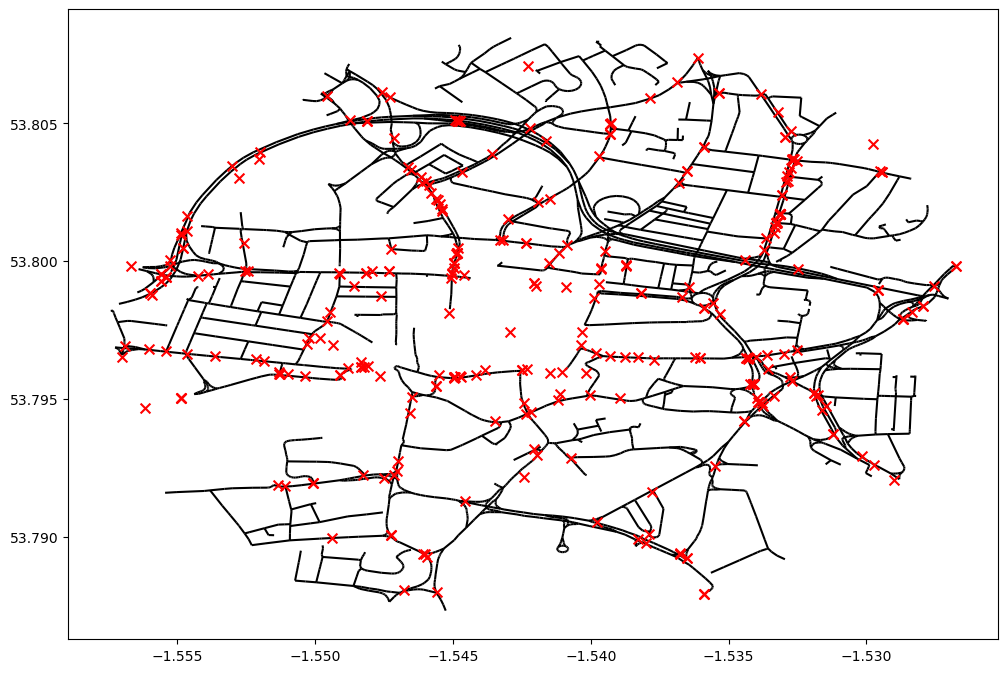

In [326]:
# This is not quite useful for analysis
# We need to snap this observation to the road network, we need
# to associate every single data point to the closest edge/street
# Show the network
base_network = edges_df.plot(color="k", zorder=0, figsize =(12, 12))
# Get a GeoDataFrame of the non-snapped (real) accident locations to plot on the net
observed_accdents=spaghetti.element_as_gdf(
    leeds_accident_area_graph, pp_name='accidents', snapped=False)

# Plot these on the road network
observed_accdents.plot(
    color="r", marker="x",
    markersize=50, zorder=1, ax=base_network)

### Snapped Version visualisation

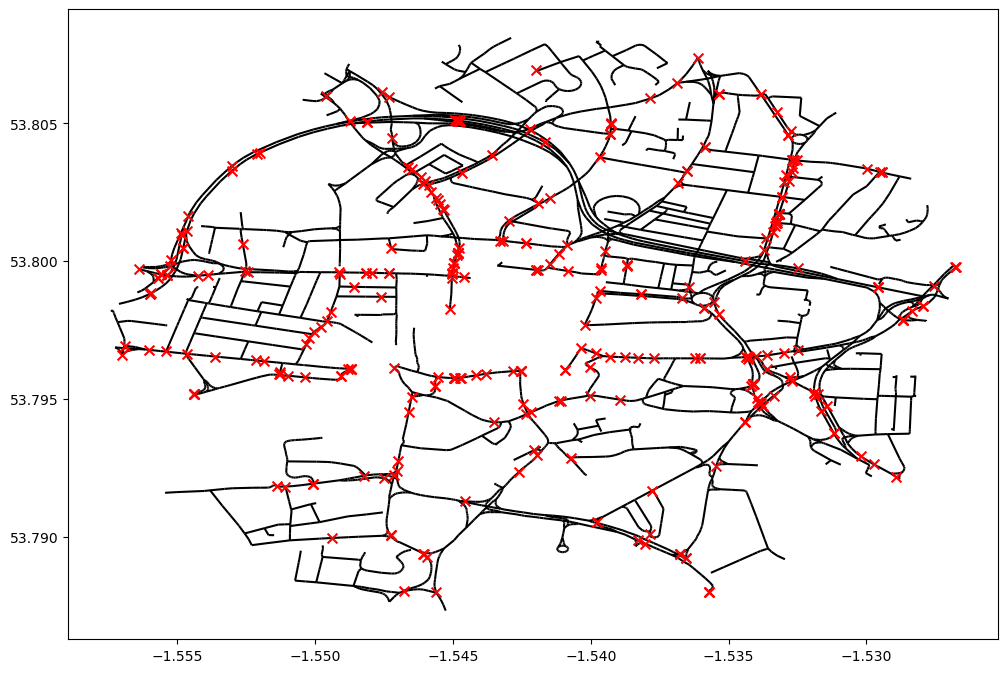

In [327]:
# Show the network
base_network = edges_df.plot(color="k", zorder=0, figsize =(12, 12))
# Get a GeoDataFrame of the snapped accident locations to plot on the network image
snapped_accidents=spaghetti.element_as_gdf(
    leeds_accident_area_graph, pp_name='accidents', snapped=True)

# Plot these on the road network
snapped_accidents.plot(
    color="r", marker="x",
    markersize=50, zorder=1, ax=base_network)

plt.show()

In [328]:
# point patterns associated with the network
# leeds_accident_area_graph.adjacencylist # List of lists storing vertex adjacency.
# leeds_accident_area_graph.vertex_coords # Keys are vertex IDs and values are (x,y) coordinates of the vertices.
# leeds_accident_area_graph.vertex_list # List of vertex IDs.
# leeds_accident_area_graph.vertices # Keys are tuples of vertex coords and values are the vertex ID
# leeds_accident_area_graph.arcs # List of arcs, where each arc is a sorted tuple of vertex IDs.
# leeds_accident_area_graph.arc_lengths # Keys are tuples of sorted vertex IDs representing an arc and values are the length.
# leeds_accident_area_graph.pointpatterns # Keys are a string name of the pattern and values are PointPattern class instances.
# leeds_accident_area_graph.distance_matrix # All network vertices (non-observations) distance matrix. Distances between vertices in disparate components are recorded as inf by default.
# leeds_accident_area_graph.network_trees # Keys are the vertex IDs (int). Values are dictionaries with the keys being the IDs of the destination vertex and values being lists of vertices along the shortest path. If the destination vertex is a) the origin or b) unreachable (disparate component) it is listed as itself being the neighbor.
# leeds_accident_area_graph.edges # Tuples of graph edge IDs.
# leeds_accident_area_graph.edge_lengths # Keys are the graph edge IDs (tuple). Values are the graph edge length (float).
# leeds_accident_area_graph.non_articulation_points # All vertices with degree 2 that are not in an isolated island ring (loop) component.
# leeds_accident_area_graph.w_networkn # Weights object created from the network arcs.
# leeds_accident_area_graph.network_n_components # Count of connected components in the network.
# leeds_accident_area_graph.network_fully_connected # True if the network representation is a single connected component, otherwise False

## Task B.2

In [329]:
''' It's computing the K-function for the road network
because we want to see if in this network with all the sccidents
plotted if there is a pattern we can identify in terms of the
possibility of clsstering of accidents in certain areas of the
network. We start with a k-function to see which distance we may
observe some pattern. This is the first insight to see what is going 
on in the network.

We compute the poroportion of neigboring nodes by increasing the distance.count

We do monte carlo simulation, rather than using the actual location of
the accidents, we basically generate possible senarios of randomly 
distributed accident locations. We do this 100 times and we compute the
k-function for each of these 100 scenarios.

'''

kres = leeds_accident_area_graph.GlobalAutoK(
    leeds_accident_area_graph.pointpatterns["accidents"],
    nsteps=100, permutations=100
)

In [330]:
kres.lam
kres.xaxis
kres.observed
kres.upperenvelope
kres.lowerenvelope
kres.sim

print(f"Density of points in the network (lambda): {kres.lam}")

Density of points in the network (lambda): 427.90993923612615


In [331]:
print(f"Distances at which density is measured:\n{kres.xaxis}")

Distances at which density is measured:
[0.         0.00048245 0.00096489 0.00144734 0.00192979 0.00241224
 0.00289468 0.00337713 0.00385958 0.00434203 0.00482447 0.00530692
 0.00578937 0.00627182 0.00675426 0.00723671 0.00771916 0.0082016
 0.00868405 0.0091665  0.00964895 0.01013139 0.01061384 0.01109629
 0.01157874 0.01206118 0.01254363 0.01302608 0.01350853 0.01399097
 0.01447342 0.01495587 0.01543831 0.01592076 0.01640321 0.01688566
 0.0173681  0.01785055 0.018333   0.01881545 0.01929789 0.01978034
 0.02026279 0.02074524 0.02122768 0.02171013 0.02219258 0.02267502
 0.02315747 0.02363992 0.02412237 0.02460481 0.02508726 0.02556971
 0.02605216 0.0265346  0.02701705 0.0274995  0.02798195 0.02846439
 0.02894684 0.02942929 0.02991173 0.03039418 0.03087663 0.03135908
 0.03184152 0.03232397 0.03280642 0.03328887 0.03377131 0.03425376
 0.03473621 0.03521866 0.0357011  0.03618355 0.036666   0.03714844
 0.03763089 0.03811334 0.03859579 0.03907823 0.03956068 0.04004313
 0.04052558 0.04100802 

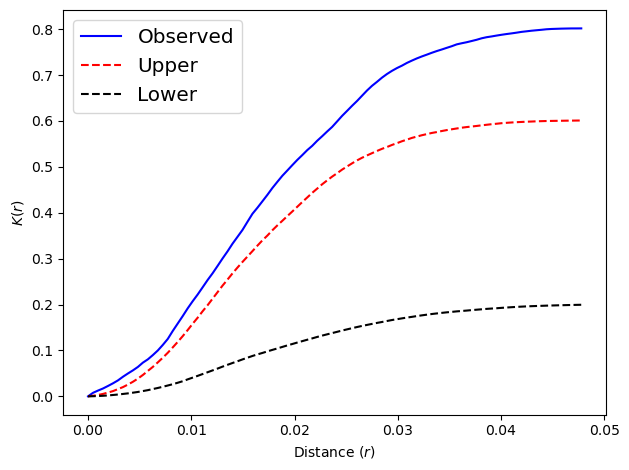

In [332]:
'''
The observes on for our accidents is the blue one, and then by 
running all those Monte Carlo simulations we have an upper
bound and a lower bound of the k-function, taking the minimum
and the maximum of all the simulations. So the average case would
be the one in between.

The red one is the optimistic case, the blue one is the pessimistic case.
There is some sort of pattern here, but it's not very clear what it is.
It is just a preliminary analysis.
'''

fig, ax = plt.subplots()

ax.plot(kres.xaxis, kres.observed, "b-", label="Observed")
ax.plot(kres.xaxis, kres.upperenvelope, "r--", label="Upper")
ax.plot(kres.xaxis, kres.lowerenvelope, "k--", label="Lower")

ax.legend(loc="best", fontsize="x-large")
ax.set_xlabel("Distance $(r)$")
ax.set_ylabel("$K(r)$")

fig.tight_layout()

In [333]:
# Get snapped point pattern 
pointpat = leeds_accident_area_graph.pointpatterns['accidents']
# Get count of points per network edge: a dictionary from each edge to the accident count on that edge
counts = leeds_accident_area_graph.count_per_link(pointpat.obs_to_arc, graph=False)
counts

{(2249, 2272): 1,
 (2496, 2497): 8,
 (52, 53): 1,
 (245, 2935): 1,
 (809, 810): 1,
 (2030, 2031): 2,
 (1412, 1423): 1,
 (757, 758): 3,
 (2923, 3186): 1,
 (587, 588): 2,
 (752, 760): 1,
 (191, 192): 1,
 (545, 546): 1,
 (2567, 2568): 3,
 (1548, 2511): 1,
 (2088, 2089): 1,
 (1488, 1489): 4,
 (1843, 1927): 1,
 (8, 9): 1,
 (71, 103): 1,
 (460, 462): 2,
 (460, 461): 4,
 (3671, 3821): 1,
 (1060, 1061): 1,
 (3735, 3736): 1,
 (1116, 1117): 1,
 (2008, 2009): 1,
 (330, 331): 1,
 (221, 222): 1,
 (2505, 3296): 1,
 (1815, 1816): 4,
 (721, 736): 2,
 (988, 989): 1,
 (2411, 2412): 3,
 (581, 1168): 1,
 (3847, 3848): 1,
 (91, 92): 1,
 (826, 827): 1,
 (364, 365): 1,
 (456, 457): 1,
 (1744, 2350): 1,
 (573, 574): 1,
 (27, 2469): 1,
 (1651, 3876): 1,
 (2137, 2138): 1,
 (64, 65): 2,
 (1737, 1738): 1,
 (977, 1893): 1,
 (3245, 3246): 2,
 (1565, 1566): 1,
 (3854, 3855): 1,
 (469, 470): 1,
 (473, 1587): 1,
 (750, 751): 1,
 (2029, 2030): 4,
 (2091, 2092): 1,
 (3474, 3475): 5,
 (2132, 2133): 3,
 (3230, 3231): 2,
 

In [334]:
# Get the weights matrix for edges in the graph (just the adjacency matrix with 1 where edges connect at a node, 0 otherwise)
weights = leeds_accident_area_graph.w_network

In [335]:
# Get the edges included in the weights matrix: an enumerator for a list of edges
edges = weights.neighbors.keys()
# Construct an array of the counts values per edge in the same order as
# the weights matrix, with 0.0 where no counts recorded
values = [counts[edge] if edge in counts.keys () else 0. \
    for index, edge in enumerate(edges)]

In [355]:
moran = esda.moran.Moran(values, weights)
moran.I


0.08582476157737938

In [356]:
moran.p_sim

0.002

The Moran's I index measures spatial autocorrelation of a variable in a given geographic area. The Moran's I index ranges between -1 and 1, where a positive value indicates positive spatial autocorrelation (i.e., similar values tend to be located near each other), a negative value indicates negative spatial autocorrelation (i.e., dissimilar values tend to be located near each other), and a value of 0 indicates no spatial autocorrelation.

In this case, the Moran's I index value is 0.08582476157737938, which is a positive value. This means that there is a tendency for similar values of the variable (which is not specified in the code) to cluster together in the geographic area being analyzed.

The p_sim value of 0.003 is the result of a Monte Carlo simulation used to test the statistical significance of the Moran's I index. It indicates the probability of obtaining the observed Moran's I index value or more extreme values by chance alone, assuming a null hypothesis of complete spatial randomness (i.e., no spatial autocorrelation). In this case, the p-value is less than 0.05, which suggests that the observed spatial autocorrelation is statistically significant at the 95% confidence level. Therefore, we can reject the null hypothesis of complete spatial randomness and conclude that there is a significant spatial pattern in the variable being analyzed.

In [357]:
moran.EI
moran.EI_sim

print(moran.EI)

-0.0002390628735357399


Text(0.5, 0, "Moran's I")

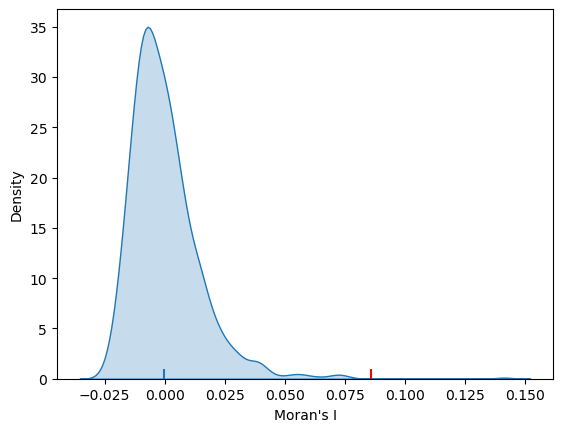

In [358]:
import seaborn as sns

sns.kdeplot(moran.sim, shade=True)
plt.vlines(moran.I, 0, 1, color='r')
plt.vlines(moran.EI, 0,1)
plt.xlabel("Moran's I")

In [359]:
moran.z_norm


5.996020097576038

In [361]:
moran.z_sim

5.88968382106923

## Task B.3

In [342]:
# Getting the coordinates of the snapped accident points
x_coord = snapped_accidents.geometry.x
y_coord = snapped_accidents.geometry.y

In [343]:
# getting the distance of the accident/node from the nearest edge
#https://osmnx.readthedocs.io/en/stable/osmnx.html?highlight=nearest#osmnx.distance.nearest_edges
distance_from_nearest_edge  = ox.distance.nearest_edges(leeds_city_center_network, x_coord, y_coord, return_dist=False)
distance_from_nearest_edge

/Users/anthoskountouris/miniconda3/envs/nda/lib/python3.9/site-packages/osmnx/distance.py:288: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = geoms.iloc[list(rtree.nearest(xy))].distance(Point(xy))


[(317032926, 317032918, 0),
 (342628235, 682264890, 0),
 (342628235, 682264890, 0),
 (342628235, 682264890, 0),
 (643929, 643930, 0),
 (1505293470, 319128731, 0),
 (342579616, 26298426, 0),
 (301673098, 1152092788, 0),
 (52167301, 342660306, 0),
 (26296947, 10652870861, 0),
 (2834744009, 21355488, 0),
 (21133756, 1599226639, 0),
 (26296949, 26296951, 0),
 (9237579, 9792558, 0),
 (21099337, 21099339, 0),
 (358204014, 5728993829, 0),
 (358204014, 5728993829, 0),
 (358204014, 5728993829, 0),
 (342647082, 52728502, 0),
 (342628235, 682264890, 0),
 (342628235, 682264890, 0),
 (342628235, 682264890, 0),
 (342628235, 682264890, 0),
 (301688528, 9319419235, 0),
 (250932750, 52638526, 0),
 (250932750, 52638526, 0),
 (250932750, 52638526, 0),
 (250932738, 250932749, 0),
 (342628235, 682264890, 0),
 (611057, 6047609602, 0),
 (643933, 643936, 0),
 (9823212, 395469503, 0),
 (9823212, 304904881, 0),
 (9755805529, 342579538, 0),
 (49556001, 301673111, 0),
 (8373170800, 244150453, 0),
 (49565569, 4955

In [344]:
from geopy.distance import distance

# Initialize lists to store distances and fractions
distances = []
fractions = []

# Looping through each nearest edge
for i, edge in enumerate(distance_from_nearest_edge):
    
    # Extracting node IDs from edge tuple
    node_start, node_end, _ = edge
    # print(f"node start: {node_start}")
    # print(f"node end: {node_end}")
    # Extracting start and end coordinates of the street segment
    street_start = (leeds_city_center_network.nodes[node_start]['y'], leeds_city_center_network.nodes[node_start]['x'])
    street_end = (leeds_city_center_network.nodes[node_end]['y'], leeds_city_center_network.nodes[node_end]['x'])
    
    # Calculate length of street segment
    street_length = distance(street_start, street_end).km
    
    # Calculating distances from accident point to start and end of street segment
    accident_coords = (y_coord[i], x_coord[i])
    distance_start = distance(accident_coords, street_start).km
    distance_end = distance(accident_coords, street_end).km
    
    # Choosing the smaller of the two distances and add it to the list of distances
    min_distance = min(distance_start, distance_end)
    # print(min_distance)
    distances.append(min_distance)

    # Calculating fraction of street segment that is closest to the accident point
    fraction = min_distance / street_length
    fractions.append(fraction)

# Calculating average distance and fraction
average_distance = sum(distances) / len(distances)
average_fraction = round(sum(fractions) / len(fractions) * 100, 2)

print('''The average proximity of the accident location to the nearest intersection is {:.2f}%, 
while the mean distance between the two is {:.2f} kilometers.'''.format(average_fraction, average_distance))

The average proximity of the accident location to the nearest intersection is 19.79%, 
while the mean distance between the two is 0.02 kilometers.


# Task C Voronoi diagrams

## Voronoi Digram

In [345]:
import numpy as np
from sklearn.cluster import KMeans

# Get the nodes and their coordinates from the network
nodes_df = ox.graph_to_gdfs(leeds_city_center_network, nodes=True, edges=False)
node_coordinates = np.column_stack((nodes_df.geometry.x, nodes_df.geometry.y))

NUMBER_OF_SEEDS = 10

# Using K-means clustering to create clusters based on the node coordinates
kmeans = KMeans(n_clusters=NUMBER_OF_SEEDS, random_state=0, max_iter=100)
cluster_labels = kmeans.fit_predict(node_coordinates)
# print(cluster_labels)
# Adding cluster labels to the nodes_df GeoDataFrame
nodes_df['cluster'] = cluster_labels
# print(nodes_df)
# Calculating the cluster centroids
cluster_centroids = kmeans.cluster_centers_
print(cluster_centroids)
# Converting cluster centroids to a GeoDataFrame
seeds = GeoDataFrame(geometry=[Point(xy) for xy in cluster_centroids])

# Get the x and y coordinates of the seeds
seeds['x'] = seeds.geometry.x
seeds['y'] = seeds.geometry.y

print(seeds)


[[-1.53227974 53.80198454]
 [-1.55364182 53.79864371]
 [-1.54071823 53.79181133]
 [-1.529719   53.79645996]
 [-1.546581   53.7991232 ]
 [-1.54906728 53.79046634]
 [-1.54713862 53.80505637]
 [-1.53445469 53.79455786]
 [-1.53767738 53.8002929 ]
 [-1.53908911 53.8055046 ]]
                    geometry         x          y
0  POINT (-1.53228 53.80198) -1.532280  53.801985
1  POINT (-1.55364 53.79864) -1.553642  53.798644
2  POINT (-1.54072 53.79181) -1.540718  53.791811
3  POINT (-1.52972 53.79646) -1.529719  53.796460
4  POINT (-1.54658 53.79912) -1.546581  53.799123
5  POINT (-1.54907 53.79047) -1.549067  53.790466
6  POINT (-1.54714 53.80506) -1.547139  53.805056
7  POINT (-1.53445 53.79456) -1.534455  53.794558
8  POINT (-1.53768 53.80029) -1.537677  53.800293
9  POINT (-1.53909 53.80550) -1.539089  53.805505


/Users/anthoskountouris/miniconda3/envs/nda/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [346]:
nearest_nodes = ox.distance.nearest_nodes(leeds_city_center_network, seeds.x, seeds.y)
print(nearest_nodes)

[52162287, 6096942942, 316814384, 317442069, 118610819, 52049934, 21545957, 342626318, 26298424, 52678071]


In [347]:
# Black color representation
black_color = (0.0, 0.0, 0.0, 1.0)  # change 'k' to RGBs value tuple (0.0, 0.0, 0.0, 1.0) if ValueError

In [348]:
def nodes_nearest_seed(graph, seeds):
    cells = nx.voronoi_cells(graph, seeds, weight='length')
    cells_inverse = {v: key for key, value in cells.items() for v in value}  # inverse cells dict
    return cells_inverse

node_seed_dict = nodes_nearest_seed(leeds_city_center_network, nearest_nodes)

In [349]:
def get_seed_color(seeds):
    seed_colors = dict(zip(seeds, ox.plot.get_colors(len(seeds))))  # {seed: seed's mapped color}
    seed_colors['unreachable'] = black_color
    return seed_colors

seed_colors = get_seed_color(nearest_nodes)

In [350]:
def map_node_color_from_seed(graph, seeds, node_seed_dict, seed_colors):
    return {node: seed_colors[node_seed_dict[node]] for node in graph.nodes}

node_color_dict = map_node_color_from_seed(leeds_city_center_network, nearest_nodes, node_seed_dict, seed_colors)

In [351]:
def map_edge_color_from_node(graph, seeds, node_seed_dict, node_colors, seed_colors):
    edge_colors = []
    for i, e in enumerate(graph.edges):
        color_pair = [node_colors[e[0]], node_colors[e[1]]]
        if black_color in color_pair:  # unreachable
            color_pair.remove(black_color)
            edge_colors.append(color_pair[0])
        elif color_pair[0] == color_pair[1]:
            edge_colors.append(color_pair[0])
        else:
            len_0 = nx.shortest_path_length(graph, node_seed_dict[e[0]], e[0], weight='length')
            len_1 = nx.shortest_path_length(graph, node_seed_dict[e[1]], e[1], weight='length')
            if len_0 <= len_1:  # or discuss on equality cases
                edge_colors.append(color_pair[0])
            else:
                edge_colors.append(color_pair[1])
    return edge_colors

edge_colors = map_edge_color_from_node(leeds_city_center_network, nearest_nodes, node_seed_dict, node_color_dict, seed_colors)

In [352]:
def update_node_colors(graph, edge_colors):
    node_colors = {}
    for i, edge in enumerate(graph.edges):
        node_colors[edge[0]] = edge_colors[i]
        node_colors[edge[1]] = edge_colors[i]
    return node_colors

node_colors_updated = update_node_colors(leeds_city_center_network, edge_colors)

# Now, you can use the updated node colors for plotting
all_nodes = list(leeds_city_center_network.nodes)
node_colors = [seed_colors[node_seed_dict[node]] if node not in nearest_nodes else 'r' for node in all_nodes]
node_colors_updated = [node_colors_updated[node] if node not in nearest_nodes else 'r' for node in all_nodes]
node_size = [50 if node in nearest_nodes else 10 for node in all_nodes]
# ox.plot.plot_graph(leeds_city_center_network, edge_color=edge_colors, node_color=node_colors_updated, node_size=node_size, bgcolor='k', save=True, filepath='nvd.png')

def plot_graph_with_seeds(graph, seeds, edge_colors, node_colors_updated, node_size, filepath, seed_size=50, seed_color='r'):
    fig, ax = ox.plot_graph(graph, edge_color=edge_colors, node_color=node_colors_updated, node_size=node_size, bgcolor='k', show=False, close=False)

    # Plot seeds separately
    for seed in seeds:
        x, y = graph.nodes[seed]['x'], graph.nodes[seed]['y']
        ax.scatter(x, y, s=seed_size, c=seed_color, zorder=3)  # zorder=3 to make sure seeds are plotted on top

    plt.savefig(filepath, dpi=300)
    # plt.close()

/Users/anthoskountouris/miniconda3/envs/nda/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1026: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


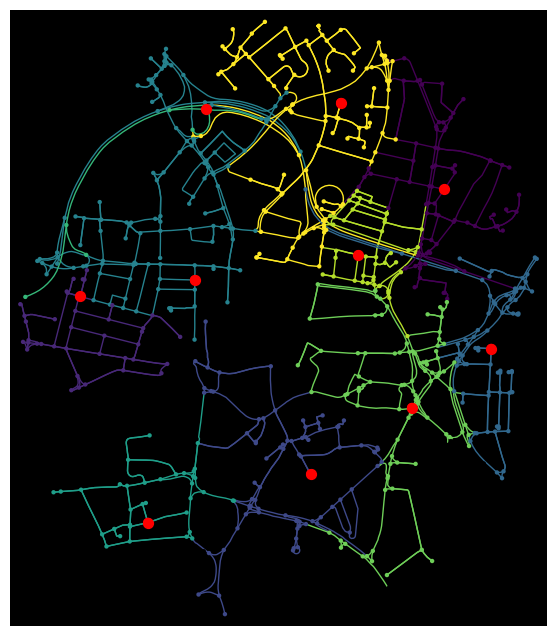

In [353]:
plot_graph_with_seeds(leeds_city_center_network, nearest_nodes, edge_colors, node_colors_updated, node_size, filepath='voronoi_with_seeds.png')

## Testing different buffering distances and number of seeds

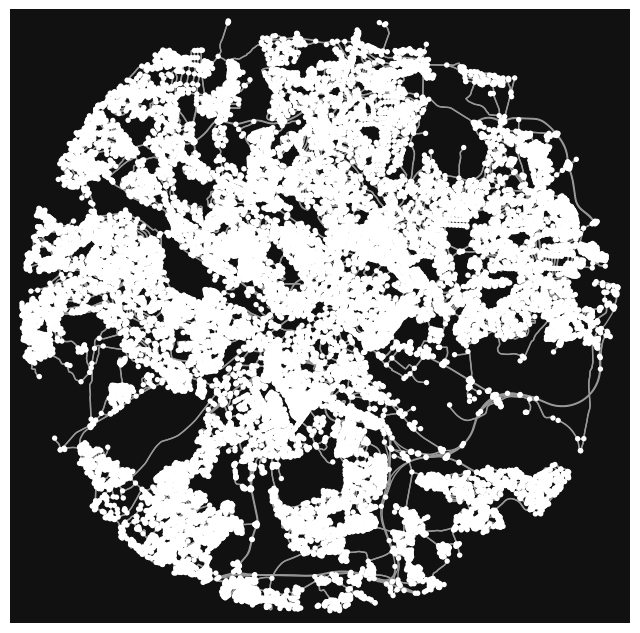

(<Figure size 800x800 with 1 Axes>, <AxesSubplot:>)

In [362]:
leeds_city_center_area = ox.geocode_to_gdf(PLACE_OF_INTEREST, buffer_dist=8000)

# From this take the polygon that defines selected area'sboundary
leeds_city_center_polygon = leeds_city_center_area['geometry'][0]
# creating the graph
leeds_city_center_network = ox.graph_from_polygon(leeds_city_center_polygon, network_type='drive')
ox.plot_graph(leeds_city_center_network)

In [363]:
# Get the nodes and their coordinates from the network
nodes_df = ox.graph_to_gdfs(leeds_city_center_network, nodes=True, edges=False)
node_coordinates = np.column_stack((nodes_df.geometry.x, nodes_df.geometry.y))

NUMBER_OF_SEEDS = 3

# Using K-means clustering to create clusters based on the node coordinates
kmeans = KMeans(n_clusters=NUMBER_OF_SEEDS, random_state=0, max_iter=100)
cluster_labels = kmeans.fit_predict(node_coordinates)

# Adding cluster labels to the nodes_df GeoDataFrame
nodes_df['cluster'] = cluster_labels

# Calculating the cluster centroids
cluster_centroids = kmeans.cluster_centers_

# Converting cluster centroids to a GeoDataFrame
seeds = GeoDataFrame(geometry=[Point(xy) for xy in cluster_centroids])

# Get the x and y coordinates of the seeds
seeds['x'] = seeds.geometry.x
seeds['y'] = seeds.geometry.y

print(seeds)

/Users/anthoskountouris/miniconda3/envs/nda/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


                    geometry         x          y
0  POINT (-1.55583 53.76508) -1.555830  53.765084
1  POINT (-1.60540 53.81396) -1.605397  53.813965
2  POINT (-1.49159 53.81072) -1.491588  53.810717


In [364]:
nearest_nodes = ox.distance.nearest_nodes(leeds_city_center_network, seeds.x, seeds.y)
print(nearest_nodes)

[412303133, 11217310, 2044769395]


In [365]:
# Black color representation
black_color = (0.0, 0.0, 0.0, 1.0)  # change 'k' to RGBs value tuple (0.0, 0.0, 0.0, 1.0) if ValueError

In [366]:
def nodes_nearest_seed(graph, seeds):
    cells = nx.voronoi_cells(graph, seeds, weight='length')
    cells_inverse = {v: key for key, value in cells.items() for v in value}  # inverse cells dict
    return cells_inverse

node_seed_dict = nodes_nearest_seed(leeds_city_center_network, nearest_nodes)

In [367]:
def get_seed_color(seeds):
    seed_colors = dict(zip(seeds, ox.plot.get_colors(len(seeds))))  # {seed: seed's mapped color}
    seed_colors['unreachable'] = black_color
    return seed_colors

seed_colors = get_seed_color(nearest_nodes)

In [368]:
def map_node_color_from_seed(graph, seeds, node_seed_dict, seed_colors):
    return {node: seed_colors[node_seed_dict[node]] for node in graph.nodes}

node_color_dict = map_node_color_from_seed(leeds_city_center_network, nearest_nodes, node_seed_dict, seed_colors)

In [369]:
def map_edge_color_from_node(graph, seeds, node_seed_dict, node_colors, seed_colors):
    edge_colors = []
    for i, e in enumerate(graph.edges):
        color_pair = [node_colors[e[0]], node_colors[e[1]]]
        if black_color in color_pair:  # unreachable
            color_pair.remove(black_color)
            edge_colors.append(color_pair[0])
        elif color_pair[0] == color_pair[1]:
            edge_colors.append(color_pair[0])
        else:
            len_0 = nx.shortest_path_length(graph, node_seed_dict[e[0]], e[0], weight='length')
            len_1 = nx.shortest_path_length(graph, node_seed_dict[e[1]], e[1], weight='length')
            if len_0 <= len_1:  # or discuss on equality cases
                edge_colors.append(color_pair[0])
            else:
                edge_colors.append(color_pair[1])
    return edge_colors

edge_colors = map_edge_color_from_node(leeds_city_center_network, nearest_nodes, node_seed_dict, node_color_dict, seed_colors)

In [370]:
def update_node_colors(graph, edge_colors):
    node_colors = {}
    for i, edge in enumerate(graph.edges):
        node_colors[edge[0]] = edge_colors[i]
        node_colors[edge[1]] = edge_colors[i]
    return node_colors

node_colors_updated = update_node_colors(leeds_city_center_network, edge_colors)

# Now, you can use the updated node colors for plotting
all_nodes = list(leeds_city_center_network.nodes)
node_colors = [seed_colors[node_seed_dict[node]] if node not in nearest_nodes else 'r' for node in all_nodes]
node_colors_updated = [node_colors_updated[node] if node not in nearest_nodes else 'r' for node in all_nodes]
node_size = [50 if node in nearest_nodes else 10 for node in all_nodes]
# ox.plot.plot_graph(leeds_city_center_network, edge_color=edge_colors, node_color=node_colors_updated, node_size=node_size, bgcolor='k', save=True, filepath='nvd.png')

def plot_graph_with_seeds(graph, seeds, edge_colors, node_colors_updated, node_size, filepath, seed_size=50, seed_color='r'):
    fig, ax = ox.plot_graph(graph, edge_color=edge_colors, node_color=node_colors_updated, node_size=node_size, bgcolor='k', show=False, close=False)

    # Plot seeds separately
    for seed in seeds:
        x, y = graph.nodes[seed]['x'], graph.nodes[seed]['y']
        ax.scatter(x, y, s=seed_size, c=seed_color, zorder=3)  # zorder=3 to make sure seeds are plotted on top

    plt.savefig(filepath, dpi=300)
    # plt.close()

/Users/anthoskountouris/miniconda3/envs/nda/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1026: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


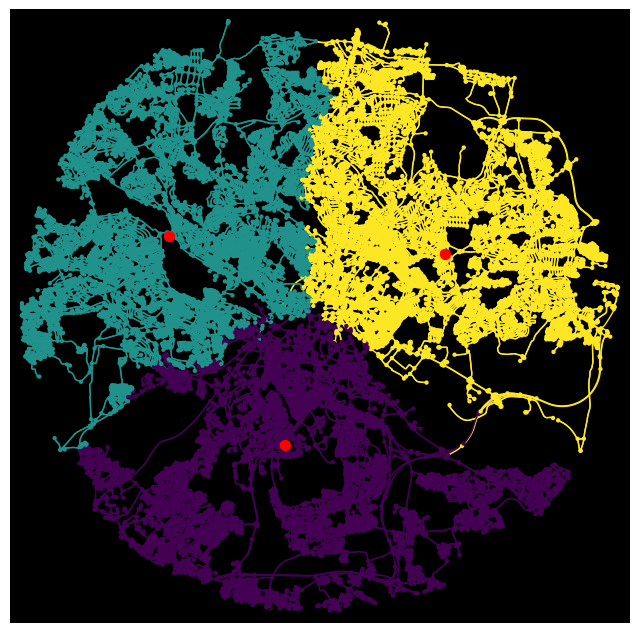

In [371]:
plot_graph_with_seeds(leeds_city_center_network, nearest_nodes, edge_colors, node_colors_updated, node_size, filepath='nvd_testing_with_seeds.png')

In [372]:
def nodes_nearest_seed(graph, seeds):
    cells = nx.voronoi_cells(graph, seeds, weight='length')
    cells_inverse = {v: key for key, value in cells.items() for v in value}  # inverse cells dict
    return cells, cells_inverse

In [373]:
voronoi_cells, node_seed_dict = nodes_nearest_seed(leeds_city_center_network, nearest_nodes)

## Finding marathon paths

In [374]:
def find_cycles_around_42km(graph, voronoi_cells, target_length=42000, tolerance=500):
    cycles_around_42km = {}

    # for each seed, cell in voronoi cells
    for seed, cell_nodes in voronoi_cells.items():
        print("cell_nodes", cell_nodes)
        # creating a subgraph of the graph with only the nodes in the cell
        subgraph = graph.subgraph(cell_nodes)
        # finding all cycles in the subgraph
        cycle_basis = nx.cycle_basis(subgraph)

        cell_cycles = []
        # for each cycle in the cycle basis
        for cycle in cycle_basis:
            # calculating the length of the cycle
            cycle_length = sum(subgraph.edges[cycle[i], cycle[i+1]]['length'] for i in range(len(cycle) - 1))
            # adding the length of the edge between the last and first node in the cycle
            cycle_length += subgraph.edges[cycle[-1], cycle[0]]['length']
            # if the cycle length is within the target length +- tolerance`
            if target_length - tolerance <= cycle_length <= target_length + tolerance:
                # add the cycle and its length to the list of cycles
                cell_cycles.append((cycle, cycle_length))
                print(f"Cycle found for seed {seed} with length {cycle_length} meters")

        cycles_around_42km[seed] = cell_cycles
        print(cycles_around_42km)
    return cycles_around_42km

In [375]:
simple_graph = nx.Graph(leeds_city_center_network)
voronoi_cells, node_seed_dict = nodes_nearest_seed(leeds_city_center_network, nearest_nodes)
cycles_around_42km = find_cycles_around_42km(simple_graph, voronoi_cells)

cell_nodes {59179023, 393838656, 393838657, 1444380754, 6726516818, 6726516821, 1929707635, 1929707637, 6297387169, 6297387173, 6297387178, 4940103858, 4940103862, 4940103863, 4940103864, 4940103865, 385188031, 8927674578, 6787596547, 59179271, 59179301, 59179331, 345801052, 345801055, 8880030052, 8880030053, 360841575, 360841582, 272007559, 59179421, 1708327331, 59179430, 59179454, 59179465, 625344973, 59179476, 4463428053, 4463428052, 441942498, 4507369958, 441942508, 59179505, 1709244917, 475365878, 441942519, 475365881, 59179515, 475365883, 1709244924, 1709244926, 1709244927, 1709244928, 441942529, 1709244923, 441942531, 475365893, 59179526, 59179536, 441942554, 59179557, 441942565, 59179578, 59179595, 59179606, 3634332248, 5169578593, 5169578603, 59179631, 5169578608, 5169578609, 5169578611, 4169990781, 59179648, 4169990785, 59179658, 59179683, 59179688, 59179694, 59179715, 59179720, 59179722, 59179728, 2291925715, 5364843227, 5364843228, 5364843229, 4169990890, 2312045291, 591797

In [376]:
num_of_cycles = len([x for x in cycles_around_42km if cycles_around_42km[x]])
print("Number of cycles in the voronoi diagram:",num_of_cycles)

Number of cycles in the voronoi diagram: 3


In [377]:
cycles_around_42km = [lst for value in cycles_around_42km.values() for lst, _ in value]
print(cycles_around_42km)

[[1716357451, 388183057, 1596692821, 1596692762, 2484909550, 1596707302, 350966, 3153467251, 1599656486, 1599664982, 9233983053, 26671933, 3153207992, 9787537, 1599666771, 268193674, 9782963, 9782953, 9782552, 403097001, 9782578, 5014679811, 403097005, 402972980, 402972833, 2872510550, 9782229, 26670300, 9782231, 1606819490, 446095207, 412281801, 1595413097, 31787367, 9781791, 9721176, 9721074, 6294553361, 6294553362, 415002736, 7441068223, 59213686, 345807172, 345805937, 345816539, 345816497, 7904956114, 412303147, 345816537, 412303120, 1022731359, 412303127, 59179924, 9217117244, 292380208, 9440308109, 1929707635, 1271219686, 412303071, 59179720, 1271219569, 1271219664, 288359232, 1271219546, 1271219660, 1271219535, 1271219594, 1271219693, 1271219598, 1271219684, 59214157, 1917844882, 288359223, 1296773677, 59214050, 1917821512, 1296773790, 1296773728, 1917821513, 1296773720, 1296777803, 1296773783, 59179694, 452140295, 452140296, 452140292, 452140300, 452140283, 1296773787, 12967737

/Users/anthoskountouris/miniconda3/envs/nda/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1026: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


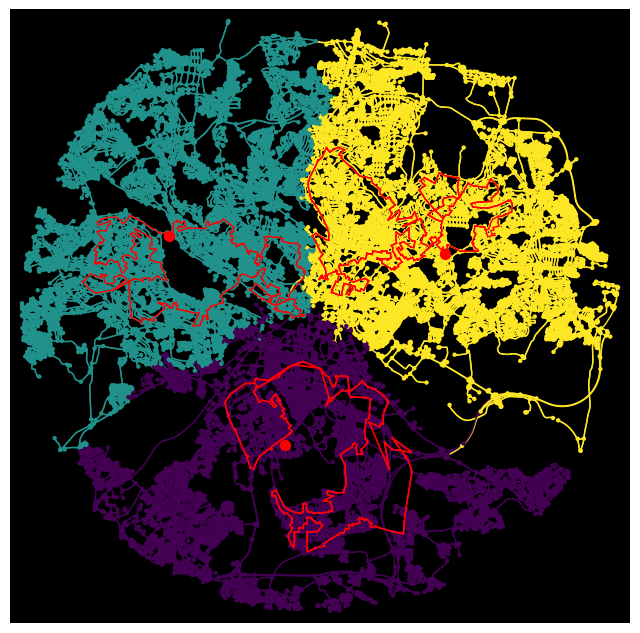

In [378]:
import matplotlib.pyplot as plt

def plot_longest_paths(graph, longest_cycles, node_colors, edge_colors, filepath):
    plot_graph_with_seeds(leeds_city_center_network, nearest_nodes, edge_colors, node_colors_updated, node_size, filepath='nvd_with_seeds.png')

    for cycle in longest_cycles:
        if cycle:
            for i in range(len(cycle)):
                start_node = cycle[i]
                end_node = cycle[(i + 1) % len(cycle)]
                start_pos = (graph.nodes[start_node]['x'], graph.nodes[start_node]['y'])
                end_pos = (graph.nodes[end_node]['x'], graph.nodes[end_node]['y'])
                plt.plot([start_pos[0], end_pos[0]], [start_pos[1], end_pos[1]], 'r-', lw=1)

    plt.savefig(filepath, dpi=300)

    plt.show()

plot_longest_paths(leeds_city_center_network, cycles_around_42km, node_colors, edge_colors, filepath='voronoi_with_marathons.png')
